In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq,
                           t_sec=length)  # either specify length in seconds
# wm = ss.WirelessMicrophone(f_sample=sample_freq, num_samples=1e5) # or number of samples
sig = wm.get_signal(f_center=1e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=signal_strength)

# print('wm.f_sample:     %6.2f' % (wm.f_sample))
# print('wm.num_samples:  %9d' % (wm.num_samples))
# print('wm.t_sec:        %6.2f' % (wm.t_sec))

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq,
                            t_sec=length)  # either specify length in seconds
# wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length) # or number of samples
noise = wgn.get_signal(dB=noise_strength)

# print('wgn.f_sample:    %6.2f' % (wgn.f_sample))
# print('wgn.num_samples: %9d' % (wgn.num_samples))
# print('wgn.t_sec:       %6.2f' % (wgn.t_sec))

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Mean:            %6.2f ' % (np.abs(noise.mean())))
print('Var:             %6.2f ' % (np.abs(noise.var())))
print('Num Samples:     %9d ' % (num_samples))

Signal power:      0.00 dB
Noise power:      -0.00 dB
SNR:               0.00 dB
Mean:              0.00 
Var:               1.00 
Num Samples:       1000000 


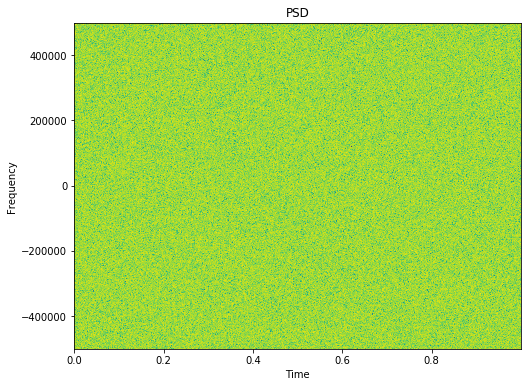

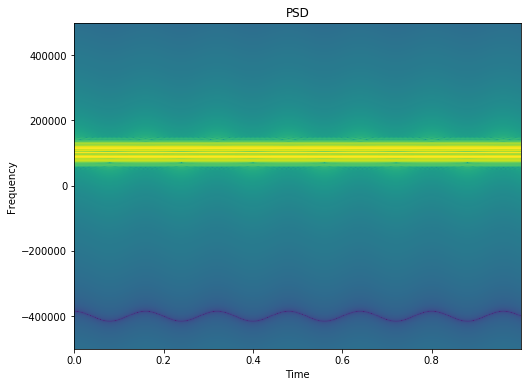

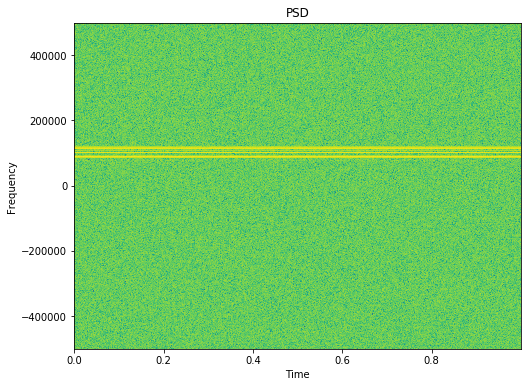

In [3]:
# Plot the resulting signals using matplotlib

plt.figure(figsize=(8, 6))
plt.specgram(noise,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(sig,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

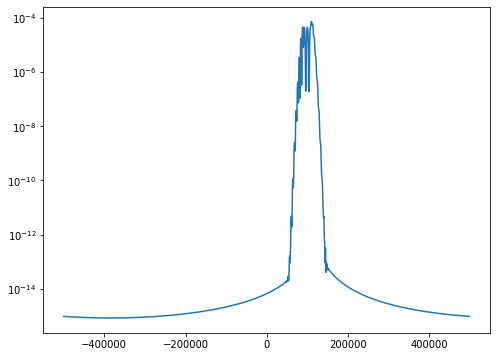

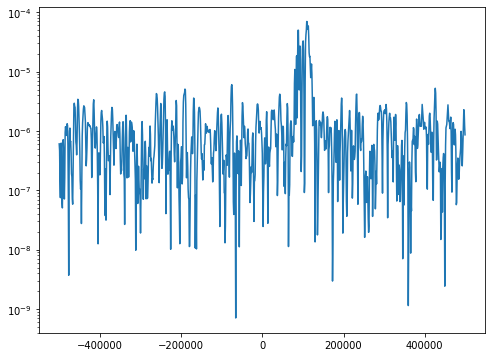

In [4]:
sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, False)

plt.figure(figsize=(8, 6))
plt.semilogy(f, x[:, 2])
plt.show()

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, False)

plt.figure(figsize=(8, 6))
plt.semilogy(f, x[:, 2])
plt.show()